<a href="https://colab.research.google.com/github/AakarshitChaurasia/Power-consumption-of-Tetouan-city-Data-Set/blob/main/time_series_forecasting_on_power_consumption_z1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics

In [ ]:
## Load data using pandas read_csv method
#df = pd.read_csv('Tetuan City power consumption.csv')
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00616/Tetuan%20City%20power%20consumption.csv"
df = pd.read_csv(url)
#Setting index to Datetime
df = df.set_index('DateTime')
df.index = pd.to_datetime(df.index)
df = df.fillna(method='ffill') # Replace missing values with the previous value
df = df.dropna()
#Visualizing dataset first 5 records
df.head()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
DateTime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [ ]:
#Checking % of Null values within dataset
missed = pd.DataFrame()

missed['column'] = df.columns

missed['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]

missed = missed.sort_values('percent',ascending=False)
print(missed)

                      column  percent
0                Temperature      0.0
1                   Humidity      0.0
2                 Wind Speed      0.0
3      general diffuse flows      0.0
4              diffuse flows      0.0
5   Zone 1 Power Consumption      0.0
6  Zone 2  Power Consumption      0.0
7  Zone 3  Power Consumption      0.0


No null values means we can proceed with EDA and Feature Engineering

# Correlation Matrix

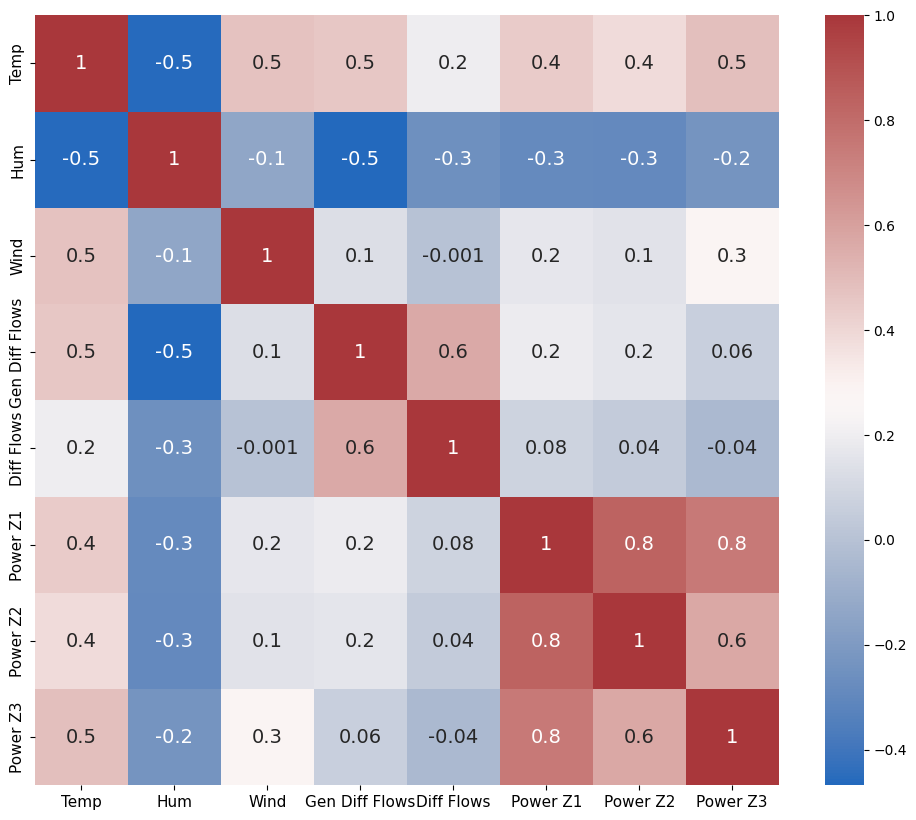

In [ ]:
##Correlation Matrix

#Renaming axis labels
axis_labels = ['Temp', 'Hum', 'Wind', 'Gen Diff Flows', 'Diff Flows', 'Power Z1', 'Power Z2', 'Power Z3']

#Setting dimensions and generating heatmap with Seaborn
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, ax=ax, cmap = 'vlag', fmt='.1g', annot_kws={
                'fontsize': 14,
                'fontweight': 'regular',
            }, xticklabels= axis_labels, yticklabels=axis_labels)

#Setting Fontsize for labels
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

#Generating plot
plt.show()

# Feature Engineering

In [ ]:
## Feature Engineering extracts the hour, day of the week, quarter, month etc. from the datetime index

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [ ]:
#Calculating 10-day, 15-day and 30-day Simple Moving Average

df['SMA10'] = df['Zone 1 Power Consumption'].rolling(10).mean()
df['SMA15'] = df['Zone 1 Power Consumption'].rolling(15).mean()
df['SMA30'] = df['Zone 1 Power Consumption'].rolling(30).mean()

df.head()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,SMA10,SMA15,SMA30
DateTime,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,0,6,1,1,2017,1,1,52,NaN,NaN,NaN
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,0,6,1,1,2017,1,1,52,NaN,NaN,NaN
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,0,6,1,1,2017,1,1,52,NaN,NaN,NaN
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,0,6,1,1,2017,1,1,52,NaN,NaN,NaN
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,0,6,1,1,2017,1,1,52,NaN,NaN,NaN


# EDA

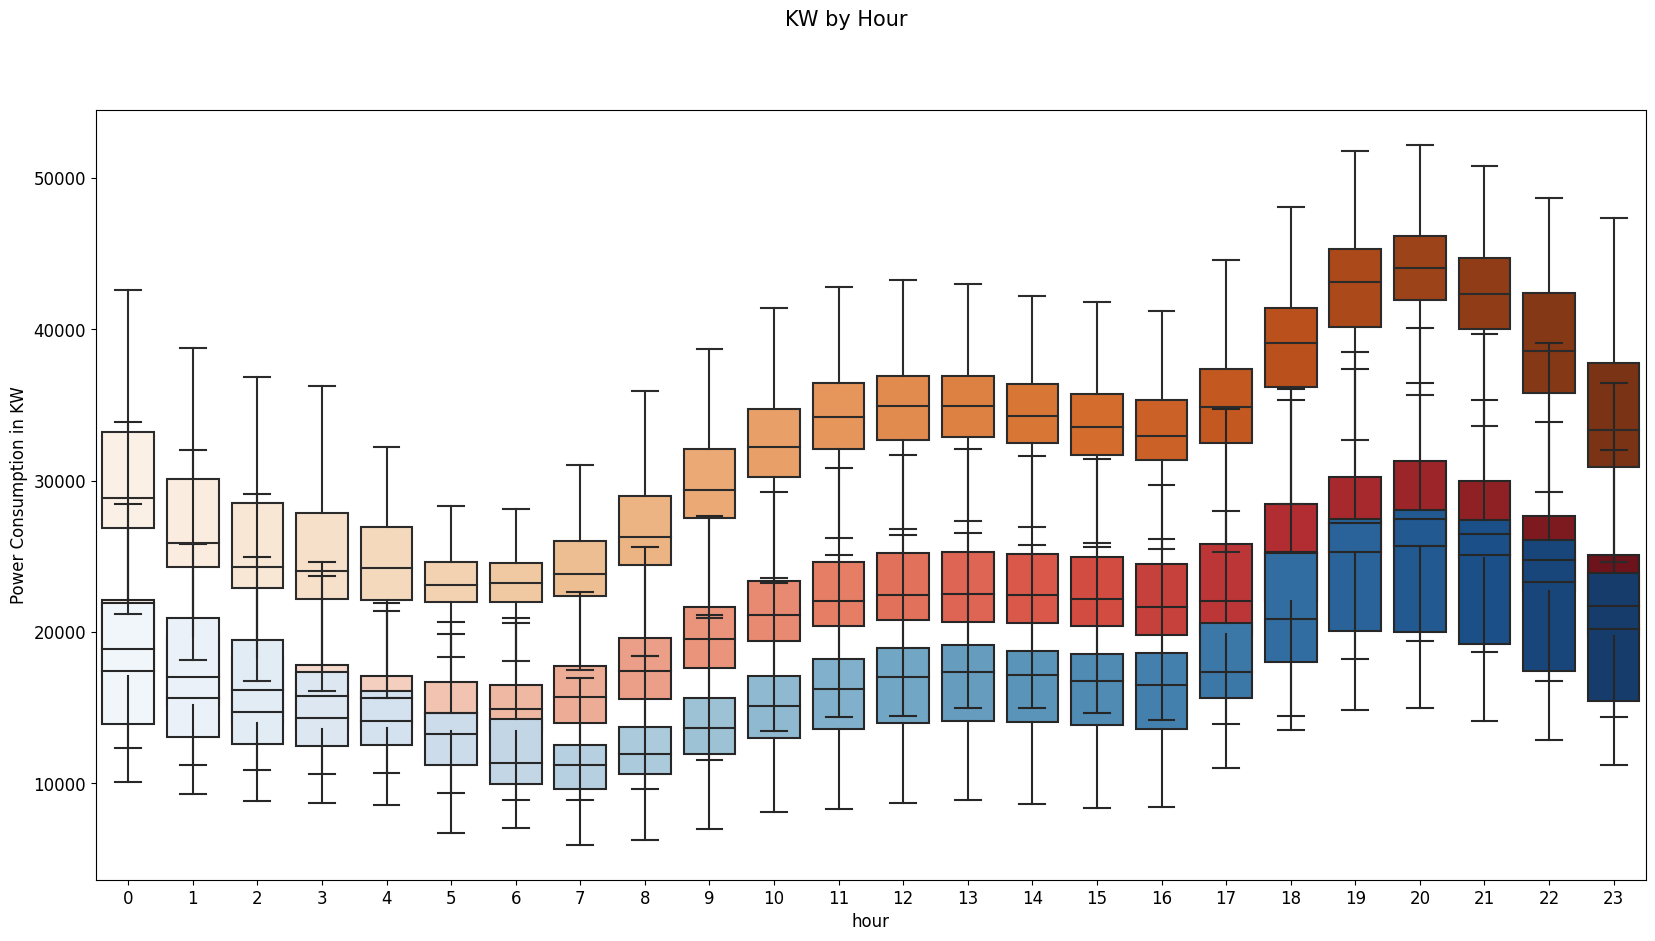

In [ ]:

fig, ax = plt.subplots(figsize=(20, 10))

zone1 = sns.boxplot(data=df, x='hour', y='Zone 1 Power Consumption', palette = 'Oranges', showfliers=False)
zone2 = sns.boxplot(data=df, x='hour', y='Zone 2  Power Consumption', palette = 'Reds', showfliers=False)
zone3 = sns.boxplot(data=df, x='hour', y='Zone 3  Power Consumption', palette = 'Blues', showfliers=False)

plt.suptitle('KW by Hour', fontsize=15)
plt.xlabel('hour', fontsize=12)
plt.ylabel('Power Consumption in KW', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Generating plot
plt.show()

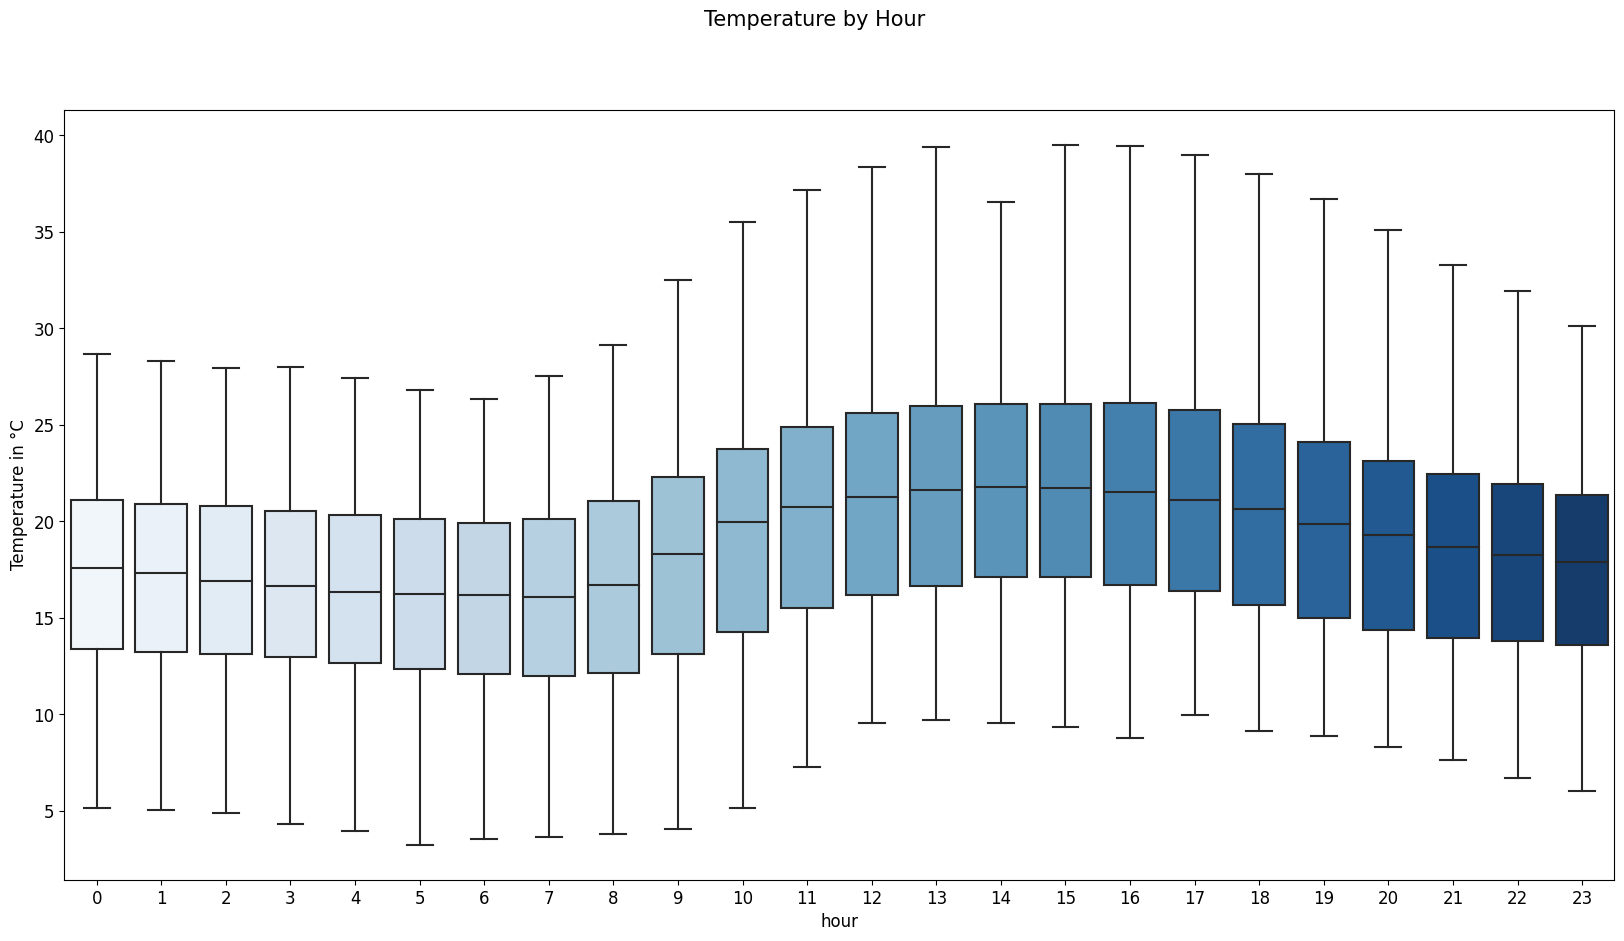

In [ ]:

fig, ax = plt.subplots(figsize=(20, 10))

sns.boxplot(data=df, x='hour', y='Temperature', palette = 'Blues', showfliers=False)

plt.suptitle('Temperature by Hour', fontsize=15)
plt.xlabel('hour', fontsize=12)
plt.ylabel('Temperature in °C', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Generating plot
plt.show()

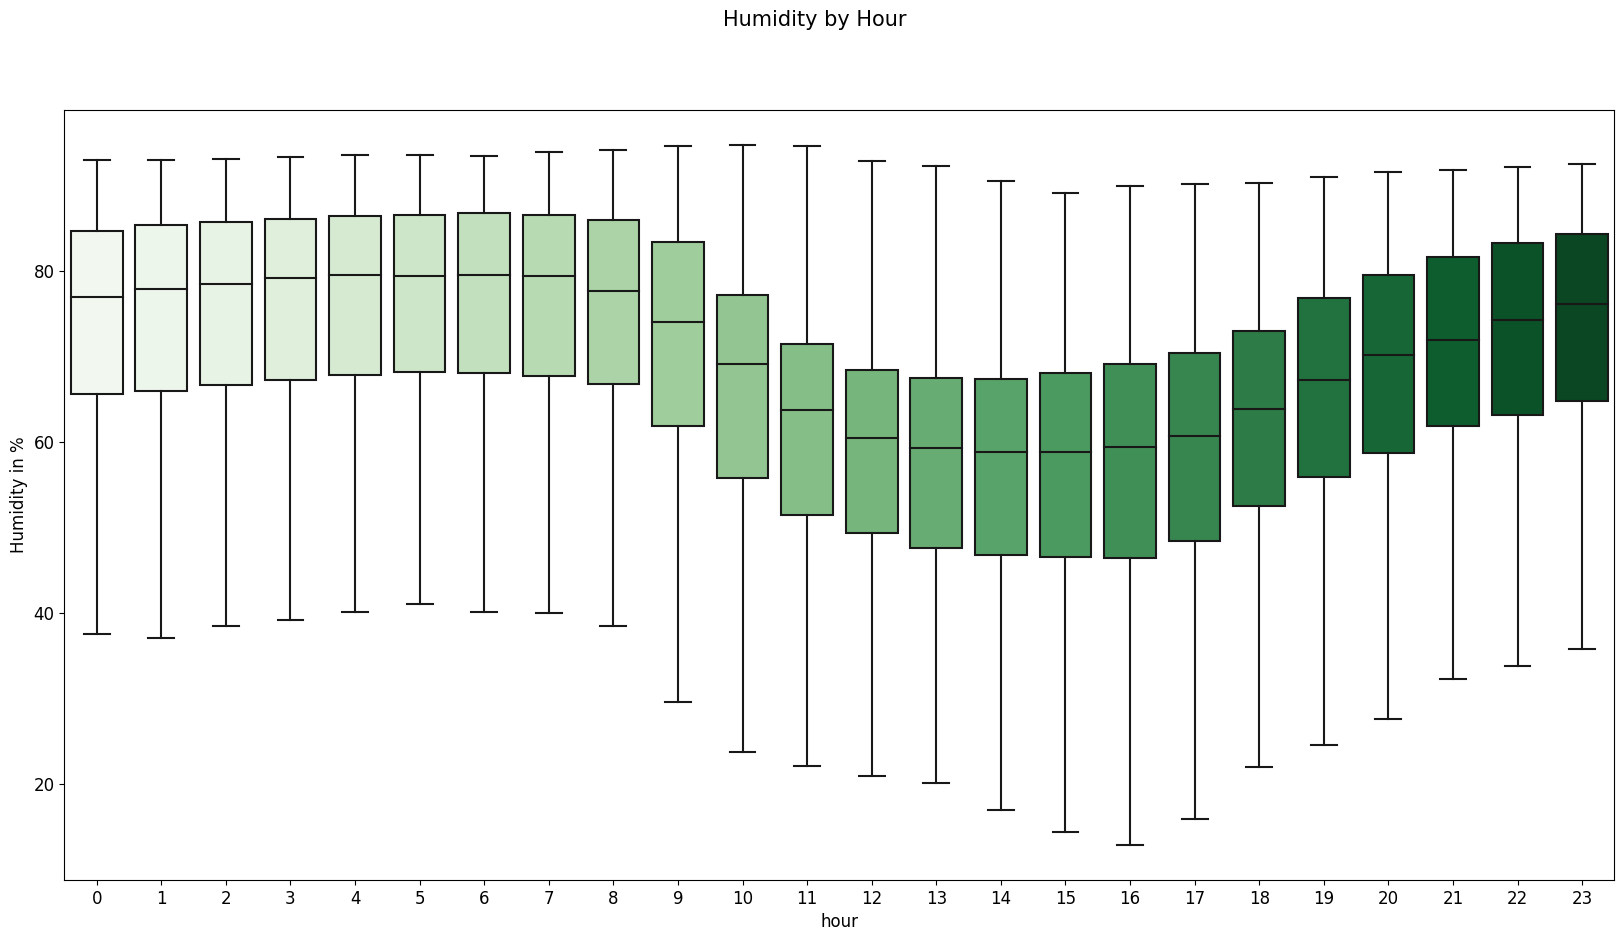

In [ ]:

fig, ax = plt.subplots(figsize=(20, 10))

sns.boxplot(data=df, x='hour', y='Humidity', palette = 'Greens', showfliers=False)

plt.suptitle('Humidity by Hour', fontsize=15)
plt.xlabel('hour', fontsize=12)
plt.ylabel('Humidity in %', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Generating plot
plt.show()

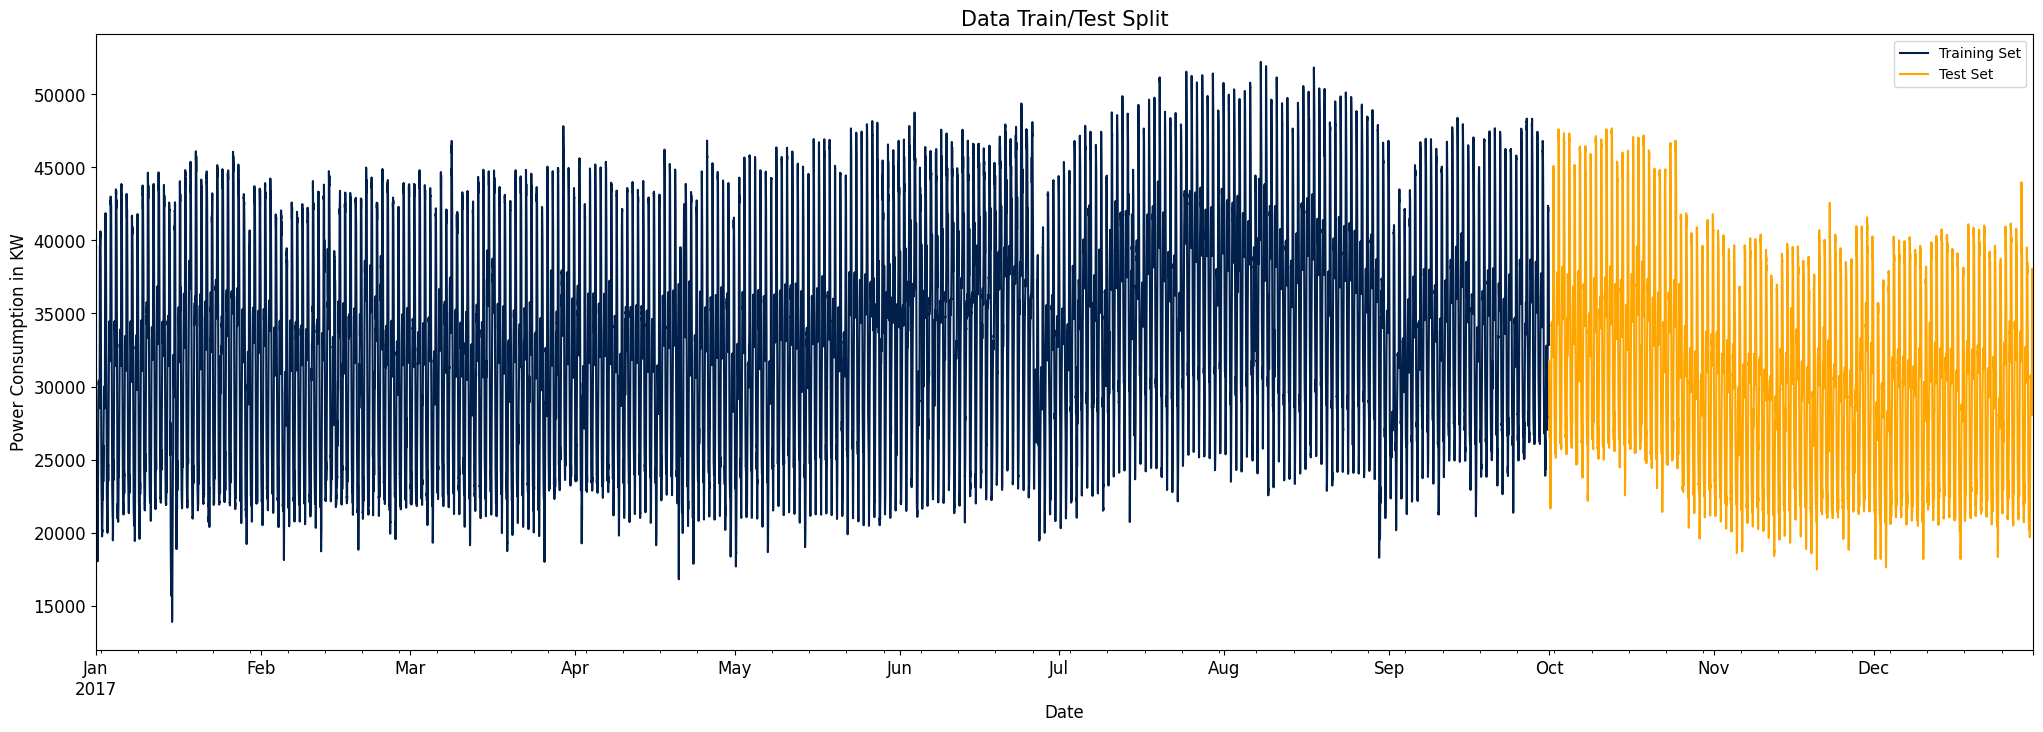

In [ ]:
#Train and Test Split
zone_1 = df['Zone 1 Power Consumption']

train = zone_1.loc[zone_1.index < '10-01-2017']
test = zone_1.loc[zone_1.index >= '10-01-2017']

fig, ax = plt.subplots(figsize=(25, 8))

train.plot(ax=ax, label='Training Set', title='Data Train/Test Split', color = "#011f4b")
test.plot(ax=ax, label='Test Set', color="orange")

ax.axvline('2017-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

plt.title('Data Train/Test Split', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption in KW', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Generating plot
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
df = df.dropna()
# Drop rows with missing values
#df = df.dropna()
X = df.loc[:'10-01-2017',['Humidity', 'Temperature', 'Wind Speed','dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year','SMA10', 'SMA30', 'SMA15']]
y = df.loc[:'10-01-2017', ['Zone 1 Power Consumption']]

# Scale X
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define models
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(max_iter=10000),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

# Define hyperparameters
params = {
    'Linear Regression': {},
    'Ridge Regression': {'alpha': [0.1, 0.5, 1, 5, 10]},
    'Lasso Regression': {'alpha': [0.1, 0.5, 1, 5, 10]},
    'Decision Tree': {'max_depth': [None, 10, 20, 30]},
    'Random Forest': {'n_estimators': [100, 500, 1000], 'max_depth': [None, 10, 20, 30]}
}


# Perform hyperparameter tuning
best_models = {}
for model_name, model in models.items():
    print(f'Tuning hyperparameters for {model_name}...')
    clf = GridSearchCV(model, params[model_name], cv=5)
    clf.fit(X_train, np.ravel(y_train))
    best_models[model_name] = clf.best_estimator_
    print(f'Best parameters for {model_name}: {clf.best_params_}')

Tuning hyperparameters for Linear Regression...
Best parameters for Linear Regression: {}
Tuning hyperparameters for Ridge Regression...
Best parameters for Ridge Regression: {'alpha': 0.1}
Tuning hyperparameters for Lasso Regression...
Best parameters for Lasso Regression: {'alpha': 0.1}
Tuning hyperparameters for Decision Tree...
Best parameters for Decision Tree: {'max_depth': 30}
Tuning hyperparameters for Random Forest...


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
# Evaluate models
results = {}
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R-squared': r2}
print(results)

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results))
width = 0.2

for i, metric in enumerate(['MSE', 'MAE', 'RMSE', 'R-squared']):
    values = [results[model_name][metric] for model_name in best_models.keys()]
    ax.bar(x + i*width, values, width, label=metric)

ax.set_xticks(x + 1.5*width)
ax.set_xticklabels(best_models.keys())
ax.legend()
plt.show()